
 # Puntos Característicos en Visión por Computadora

 Los puntos característicos son ubicaciones en una imagen que son "fáciles" de encontrar en futuras capturas. Una técnica clásica de detección de características, como el método de Lucas-Kanade (a veces llamado Kanade-Lucas-Tomasi o KLT), se originó a partir de un artículo titulado "Good features to track".

 Mientras que los bordes encuentran discontinuidades en el brillo de una imagen, los puntos característicos encuentran regiones distintivas. Existen diferentes detectores de características, todos con algunos principios en común: deben ser fáciles de encontrar, y las cosas que están cerca en el espacio de la imagen también deben estar cerca en el espacio de características (es decir, la representación de una característica debe parecerse a la de otra característica similar).

 Si deseas un tutorial más profundo sobre características en OpenCV, puedes encontrar uno [aquí](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%

# Importaciones esenciales para el uso de OpenCV
import cv2  # OpenCV en sí
import numpy as np  # Para manipulaciones de matrices

# Importaciones adicionales para el notebook interactivo
%matplotlib inline
from matplotlib import pyplot as plt  # Para graficar imágenes en el notebook
import pylab  # Para configurar el tamaño de las figuras
pylab.rcParams['figure.figsize'] = (10.0, 8.0)  # Configura el tamaño de la figura

# Cargamos una imagen de entrada
input_image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/noidea.jpg")


 ## Detectores de Esquinas

 Si pensamos en los bordes como líneas, entonces las esquinas son una elección obvia para los puntos característicos, ya que representan la intersección de dos líneas. Uno de los detectores de esquinas más antiguos y efectivos es el de Harris, que sigue siendo ampliamente utilizado. Este detector es confiable y rápido.

 El detector de esquinas de Harris encuentra regiones de la imagen con cambios rápidos en diferentes direcciones. Aquí aplicamos el detector de Harris a una imagen de prueba.

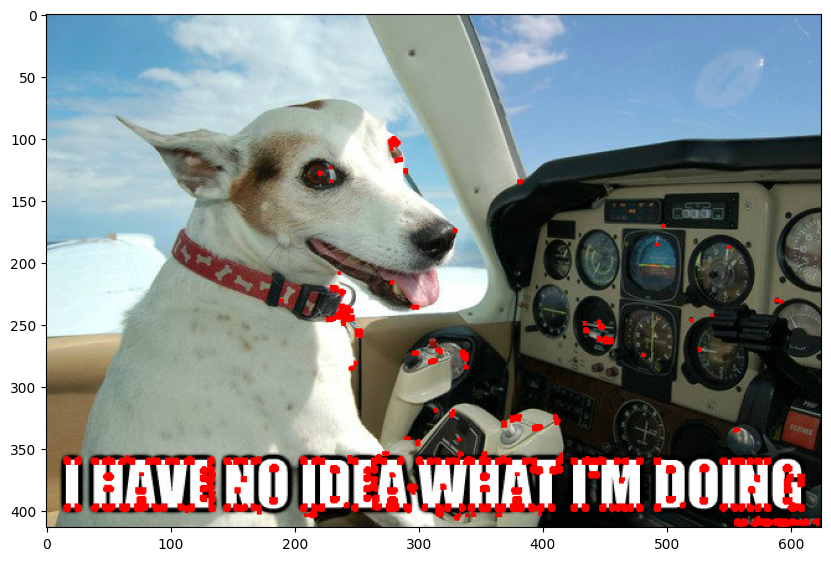

In [ ]:
# %%

harris_test = input_image.copy()
# Convertimos la imagen a escala de grises
gray = cv2.cvtColor(harris_test, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# Parámetros de la función de Harris
blocksize = 4  # Tamaño del bloque para el cálculo de esquinas
kernel_size = 3  # Tamaño del kernel de Sobel

# Aplicamos el detector de esquinas de Harris
dst = cv2.cornerHarris(gray, blocksize, kernel_size, 0.05)

# Para efectos visuales, dilatamos el resultado para que las esquinas se vean más grandes
dst = cv2.dilate(dst, None)
# Visualizamos las esquinas en la imagen usando rojo brillante
harris_test[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(cv2.cvtColor(harris_test, cv2.COLOR_BGR2RGB))


 La detección de esquinas de Harris funciona de forma similar al operador de Sobel, ya que no devuelve un conjunto de características como tal, sino que genera una respuesta fuerte en las regiones de la imagen con características similares a esquinas.

 Observemos la salida de Harris para ver cómo se destacan las zonas con posibles esquinas.

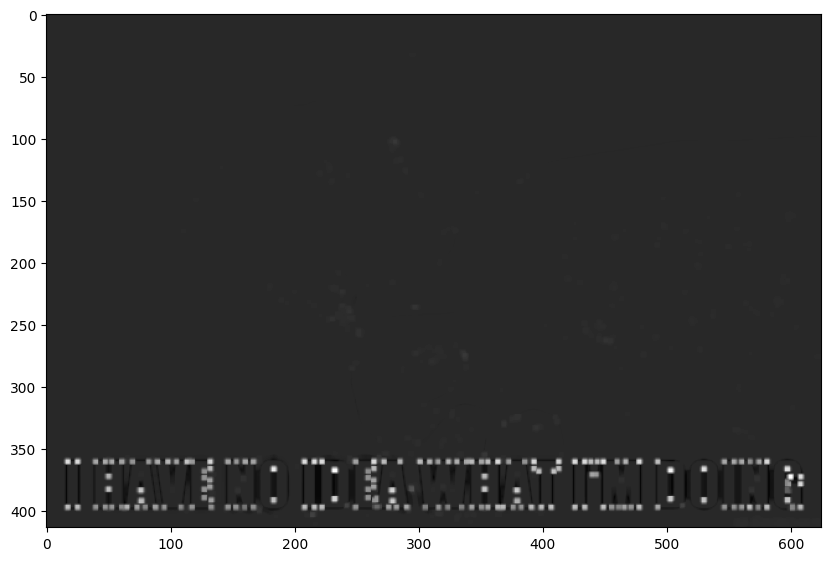

In [ ]:
# %%

plt.imshow(dst, cmap='gray')


 ## Avanzando hacia el Espacio de Características

 Para los detectores de características modernos, existen varios criterios importantes para definir una buena característica:

 - **Repetibilidad**: debe ser posible encontrarla de nuevo.
 - **Distintividad**: diferentes características deben ser diferentes entre sí.
 - **Localidad**: deben ser locales y no abarcar toda la imagen.
 - **Cantidad**: debe haber suficientes características detectadas para que sean útiles.
 - **Precisión**: deben ubicar las características de la imagen de forma precisa.
 - **Eficiencia**: deben poder calcularse en un tiempo razonable.

 Estos principios se encuentran en un buen estudio que puedes consultar [aquí](http://campar.in.tum.de/twiki/pub/Chair/TeachingWs09MATDCV/FT_survey_interestpoints08.pdf).


 ## Detección de Características con ORB

 ORB (Oriented FAST and Rotated BRIEF) es un detector y descriptor de características rápido y eficiente. Primero encuentra los puntos de interés (keypoints) y luego calcula descriptores alrededor de esos puntos para hacerlos más distintivos y facilitar la coincidencia entre imágenes.

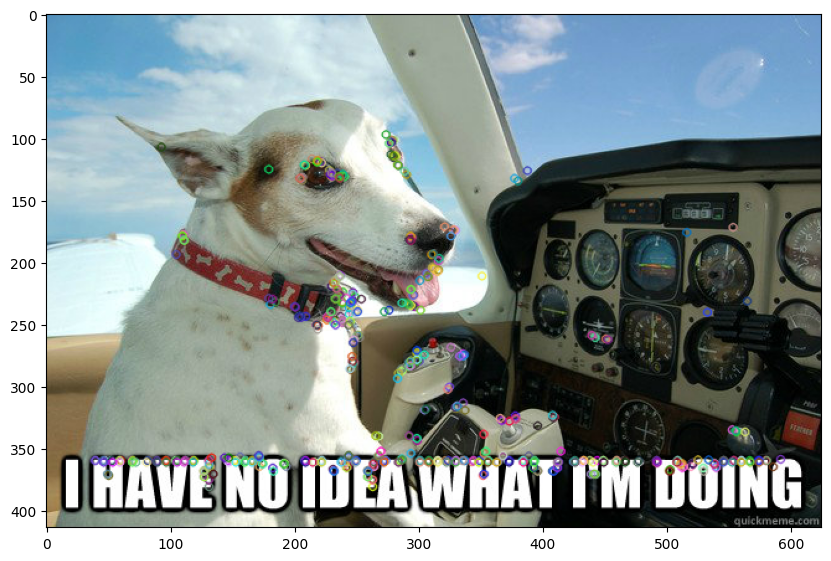

In [ ]:
# %%

orbimg = input_image.copy()

# Crear el objeto ORB
orb = cv2.ORB_create()
# Detectar puntos de interés con ORB
kp = orb.detect(orbimg, None)
# Calcular los descriptores
kp, des = orb.compute(orbimg, kp)
# Dibujar puntos de interés en la imagen
cv2.drawKeypoints(orbimg, kp, orbimg)

plt.imshow(cv2.cvtColor(orbimg, cv2.COLOR_BGR2RGB))




 ## Coincidencia de Características

 Encontrar características es solo el primer paso; el objetivo es usar estas características para hacer coincidencias entre imágenes. Vamos a crear una imagen manipulada donde sepamos que habrá una coincidencia de características.

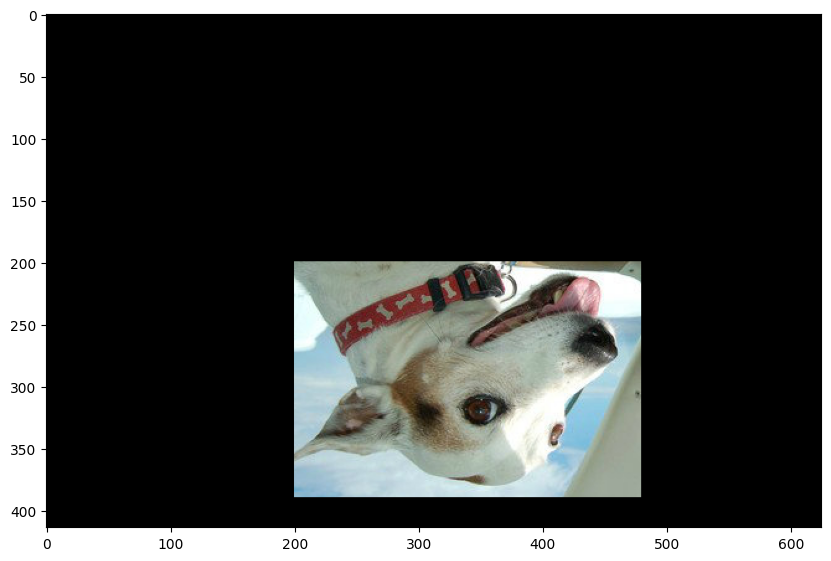

In [ ]:
# %%

img2match = np.zeros(input_image.shape, np.uint8)
dogface = input_image[60:250, 70:350]  # Copiamos una región
img2match[60:250, 70:350] = [0, 0, 0]  # Borramos esa región en la imagen de coincidencia
dogface = cv2.flip(dogface, 0)  # Invertimos la copia
# Pegamos la región manipulada en otra ubicación de la imagen
img2match[200:200 + dogface.shape[0], 200:200 + dogface.shape[1]] = dogface

plt.imshow(cv2.cvtColor(img2match, cv2.COLOR_BGR2RGB))


 ## Coincidencia de Puntos Clave

 La función de coincidencia de características detecta y luego calcula descriptores para los puntos clave. Los descriptores son una representación de mayor dimensión de la región de la imagen alrededor de un punto de interés.

 Estos descriptores se pueden emparejar utilizando un objeto de coincidencia de fuerza bruta (BFMatcher) que compara los descriptores utilizando una medida de distancia especificada.

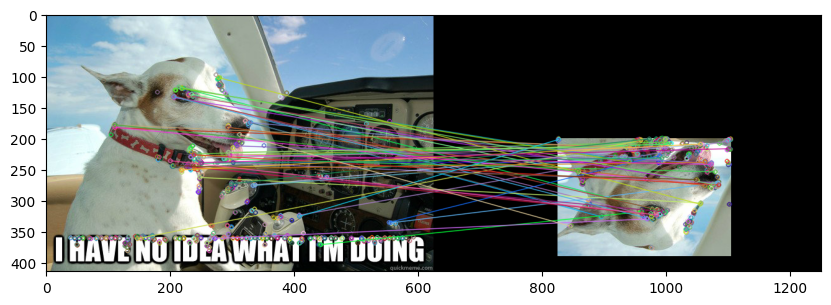

In [ ]:
# %%

kp2 = orb.detect(img2match, None)
# Calculamos los descriptores para la imagen modificada
kp2, des2 = orb.compute(img2match, kp2)
# Crear el objeto BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Emparejar los descriptores
matches = bf.match(des, des2)

# Ordenar los emparejamientos por distancia en el espacio de características
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar los primeros 50 emparejamientos
oimg = cv2.drawMatches(orbimg, kp, img2match, kp2, matches[:50], orbimg)

plt.imshow(cv2.cvtColor(oimg, cv2.COLOR_BGR2RGB))


 Como puedes ver, existen algunas coincidencias falsas, pero es bastante claro que la mayoría de los puntos clave coinciden entre regiones similares de ambas imágenes.

 Para ser más precisos en nuestra coincidencia, podríamos aplicar restricciones de **homografía**, que buscan características en el mismo plano. Puedes explorar más sobre este tema en el siguiente tutorial: [http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html]


 # Modelos de Coincidencia de Características en Visión por Computadora


 ## Conceptos Básicos

 - **Puntos clave (Keypoints)**: son puntos de interés en la imagen, seleccionados según propiedades específicas alrededor de ellos (como esquinas). Existen varios algoritmos para detectarlos, como ORB, SIFT y SURF.
 - **Descriptores**: son vectores que resumen las propiedades de un punto clave. Se usan para clasificar el punto clave y realizar coincidencias entre imágenes. [Aquí puedes leer más sobre descriptores](https://gilscvblog.com/2013/08/18/a-short-introduction-to-descriptors/).
 - **Características (Features)**: son el punto clave junto a su descriptor. Diferentes algoritmos utilizan métodos distintos para determinar una característica.

 ### Métodos que exploraremos:

 1. Coincidencia por Fuerza Bruta (Brute-Force) con descriptores ORB.
 2. Coincidencia por Fuerza Bruta con descriptores SIFT y prueba de razón (Ratio Test).
 3. Coincidencia basada en FLANN, que usa la detección de características locales con SIFT.

In [ ]:
# %%

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# %%

def display(img, cmap='gray'):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap=cmap)

 ### Las Imágenes que Usaremos

 Utilizaremos una imagen de un "objeto" que queremos buscar en una "imagen grande" que contiene ese objeto junto a otros elementos.

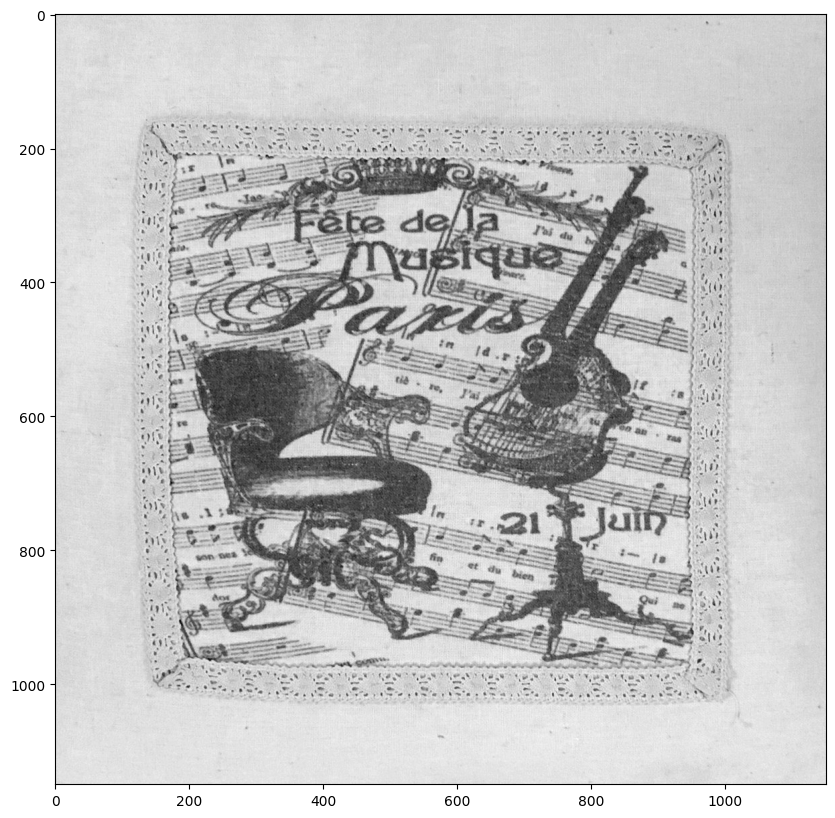

In [24]:
# %%

item = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/item.jpg', cv2.IMREAD_GRAYSCALE)
display(item)

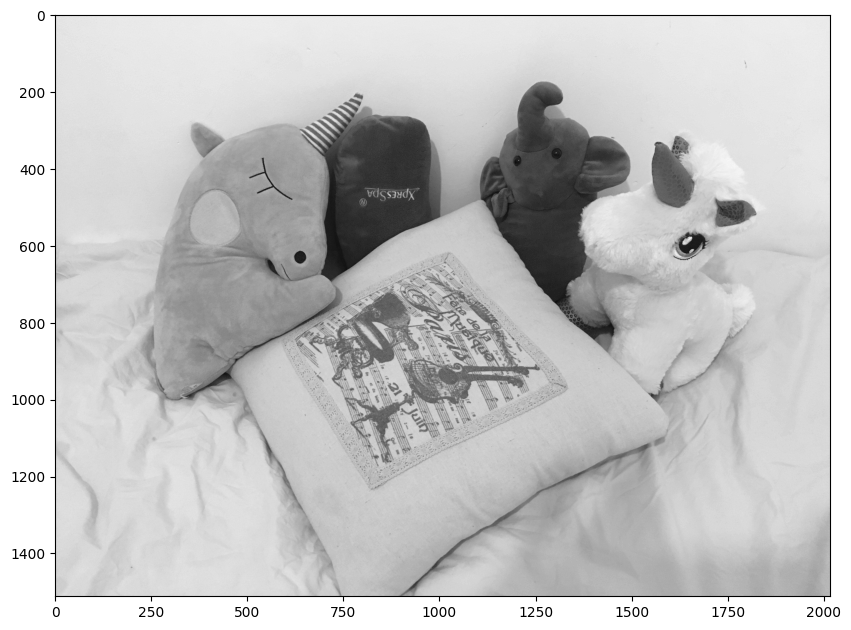

In [25]:
# %%

big_picture = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/big_picture.jpg', cv2.IMREAD_GRAYSCALE)
display(big_picture)


 ## Puntos Clave en ORB y SIFT

 ORB y SIFT son algoritmos para detectar puntos clave y calcular sus descriptores. ORB es un algoritmo rápido y eficiente en cuanto a procesamiento, mientras que SIFT es más preciso, pero computacionalmente más pesado.

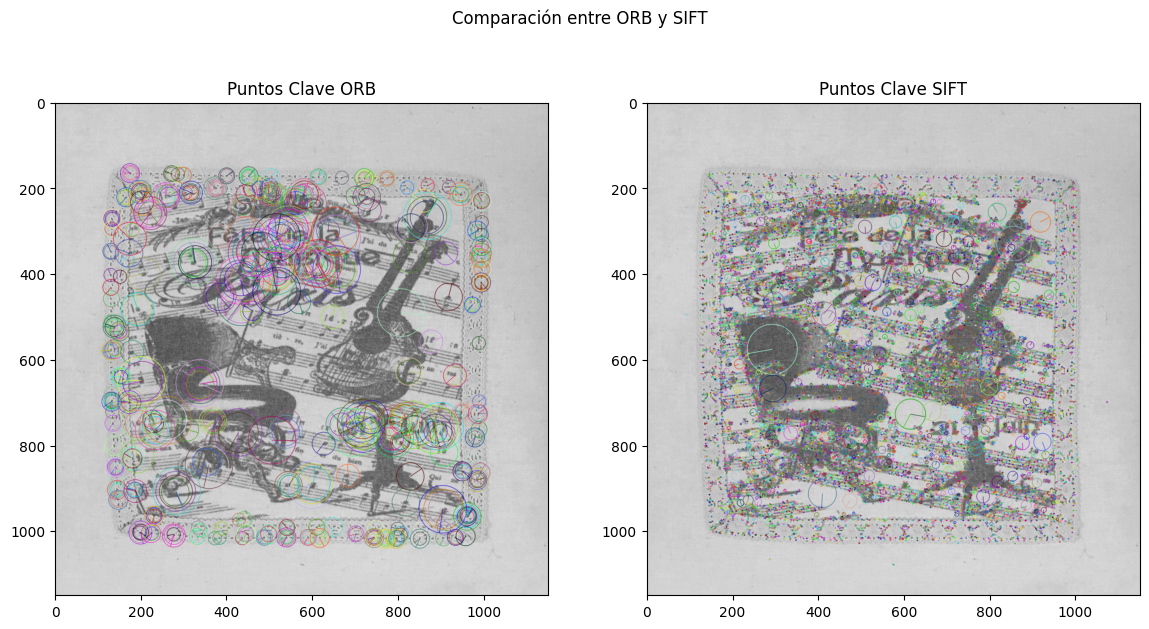

In [26]:
# %%
ruta_item="/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/item.jpg"
item_okp = cv2.imread(ruta_item)
item_skp = item_okp.copy()
draw_flag = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

# Crear detector ORB y detectar puntos clave
orb = cv2.ORB_create()
okp, odes = orb.detectAndCompute(item, None)
# Dibujar puntos clave ORB
cv2.drawKeypoints(image=item, keypoints=okp, outImage=item_okp, flags=draw_flag)

# Crear detector SIFT y detectar puntos clave
sift = cv2.xfeatures2d.SIFT_create()
skp, sdes = sift.detectAndCompute(item, None)
# Dibujar puntos clave SIFT
cv2.drawKeypoints(image=item, keypoints=skp, outImage=item_skp, flags=draw_flag)

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(item_okp)
plt.title('Puntos Clave ORB')

plt.subplot(122)
plt.imshow(item_skp)
plt.title('Puntos Clave SIFT')
plt.suptitle("Comparación entre ORB y SIFT")
plt.show()


 ## Coincidencia por Fuerza Bruta con Descriptores ORB

 Este método de coincidencia busca el descriptor más cercano en el espacio de características para cada punto clave.

 - `cv2.BFMatcher`: Este objeto de OpenCV permite la coincidencia de características mediante una búsqueda de "fuerza bruta".
 - `cv2.NORM_HAMMING`: Es una medida de distancia específica para descriptores binarios como los de ORB.

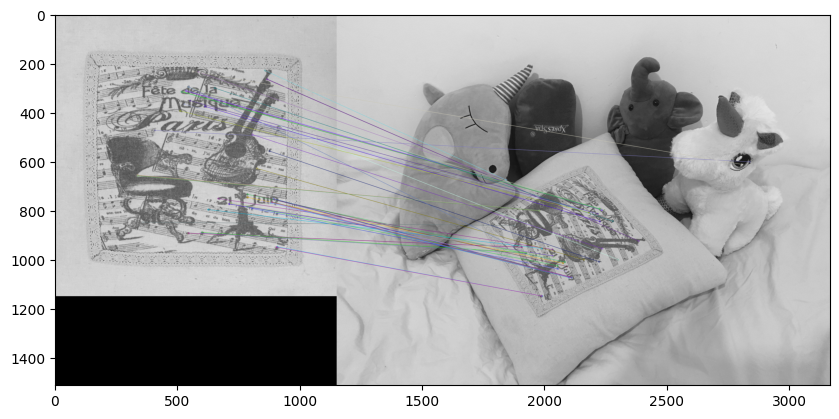

In [27]:
# %%

# Inicializamos el detector ORB
orb = cv2.ORB_create()

# Detectar puntos clave y calcular descriptores con ORB
kp1, des1 = orb.detectAndCompute(item, None)
kp2, des2 = orb.detectAndCompute(big_picture, None)

# Crear objeto BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Emparejar descriptores
matches = bf.match(des1, des2)

# Ordenar coincidencias por distancia
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las primeras 50 coincidencias
item_matches = cv2.drawMatches(item, kp1, big_picture, kp2, matches[:50], None, flags=2)
display(item_matches)


 ## Coincidencia por Fuerza Bruta con Descriptores SIFT y Prueba de Razón

 Usamos la prueba de razón de Lowe para mejorar la precisión de las coincidencias. Esta prueba establece que una coincidencia es buena solo si la razón entre la mejor coincidencia y la segunda mejor coincidencia es inferior a un umbral (usualmente 0.7).

 Este método es útil cuando trabajamos con descriptores SIFT que son más detallados que los de ORB.

1296 buenas coincidencias encontradas


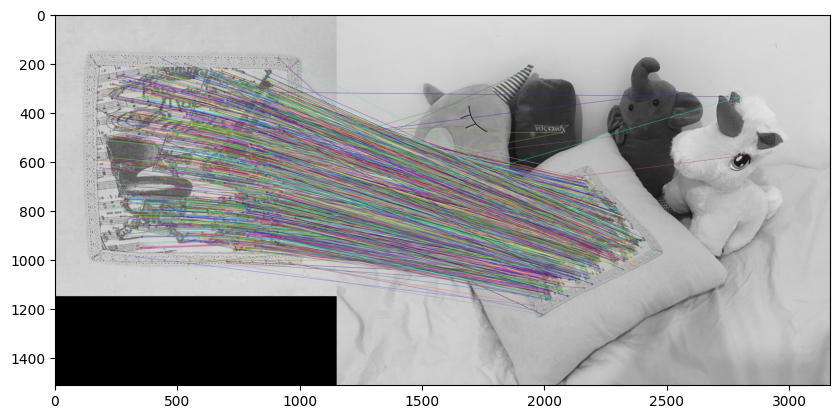

In [28]:
# %%

# Crear objeto SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Detectar puntos clave y calcular descriptores con SIFT
kp1, des1 = sift.detectAndCompute(item, None)
kp2, des2 = sift.detectAndCompute(big_picture, None)

# Crear objeto BFMatcher con parámetros por defecto
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Aplicar la prueba de razón
good = []
for match1, match2 in matches:
    if match1.distance < 0.7 * match2.distance:
        good.append([match1])

print(f"{len(good)} buenas coincidencias encontradas")

# Dibujar coincidencias usando drawMatchesKnn
sift_matches = cv2.drawMatchesKnn(item, kp1, big_picture, kp2, good, None, flags=2)
display(sift_matches)


 ## Coincidencia Basada en FLANN

 FLANN (Fast Library for Approximate Nearest Neighbors) es un método de coincidencia rápido y eficiente, especialmente útil para grandes conjuntos de datos. Funciona bien con descriptores SIFT.

 - `cv2.FlannBasedMatcher`: Utiliza un método rápido de coincidencia aproximada en lugar de la coincidencia exacta de fuerza bruta.
 - `index_params`: Define el tipo de algoritmo a usar (en este caso, K-D Tree).
 - `search_params`: Controla el número de veces que se realiza la búsqueda en el conjunto de datos.

1296 buenas coincidencias encontradas


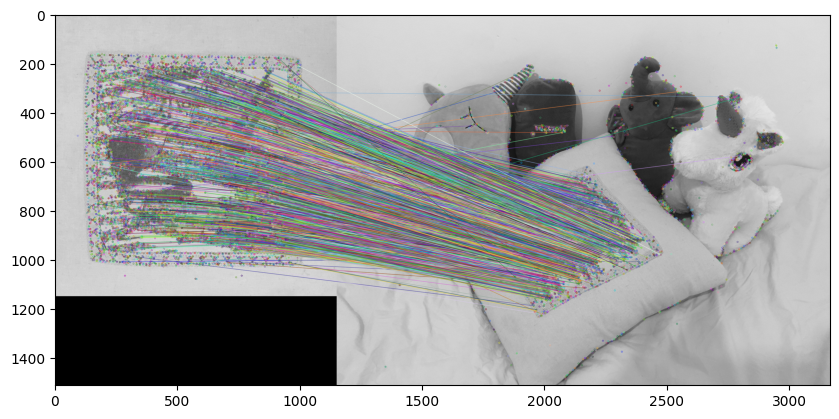

In [29]:
# %%

# Inicializar detector SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Detectar puntos clave y calcular descriptores con SIFT
kp1, des1 = sift.detectAndCompute(item, None)
kp2, des2 = sift.detectAndCompute(big_picture, None)

# Parámetros de FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

good = []

# Aplicar la prueba de razón
for match1, match2 in matches:
    if match1.distance < 0.7 * match2.distance:
        good.append([match1])

print(f"{len(good)} buenas coincidencias encontradas")

# Dibujar coincidencias
flann_matches = cv2.drawMatchesKnn(item, kp1, big_picture, kp2, good, None, flags=0)
display(flann_matches)


 # Homografía a partir de la Coincidencia de Características SIFT

 En este ejemplo, utilizaremos el algoritmo SIFT para detectar y emparejar puntos característicos entre dos imágenes: una imagen de un objeto y una imagen de ese objeto dentro de una escena. A partir de esas coincidencias, calcularemos la homografía para detectar la ubicación del objeto en la escena.

 ## 1. Coincidencia de Características con SIFT

80 coincidencias encontradas


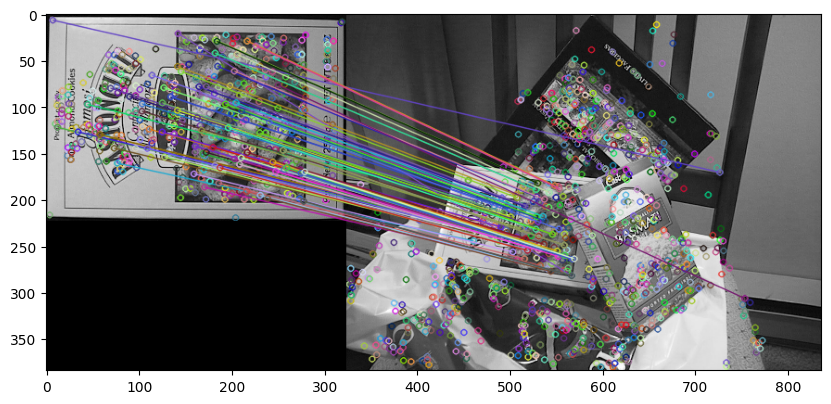

In [ ]:
# %%

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Abrir y mostrar imágenes
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/box.png')  # Imagen del objeto
img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-03/box_in_scene.png')  # Imagen del objeto en la escena

# Extracción de características SIFT
sift = cv2.xfeatures2d.SIFT_create()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detectar puntos clave y calcular descriptores
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Coincidencia de características con el emparejador de fuerza bruta (BFMatcher)
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

# Aplicar la prueba de razón de Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print(f"{len(good_matches)} coincidencias encontradas")

# Dibujar las coincidencias
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))


 ## 2. Calcular la Matriz de Homografía y Detectar el Objeto

 Utilizamos los puntos coincidentes para calcular la matriz de homografía. La homografía nos permite transformar los puntos de la imagen del objeto para que coincidan con los puntos en la escena.

In [ ]:
# %%

# Obtener puntos de coincidencia en ambas imágenes
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1, 1, 2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1, 1, 2)

print("Puntos en la imagen del objeto:", src_pts[:3])
print("Puntos en la imagen de la escena:", dst_pts[:3])

Puntos en la imagen del objeto: [[[  6.894549    6.1633663]]

 [[ 12.016468  121.74898  ]]

 [[ 34.13518   126.633545 ]]]
Puntos en la imagen de la escena: [[[402.3577  170.31084]]

 [[179.8987  240.98431]]

 [[119.68747 224.40521]]]



 ### Encontrar la Matriz de Homografía

 Usamos el algoritmo RANSAC para calcular la homografía que mejor transforma los puntos de la imagen del objeto a los puntos de la escena, minimizando el efecto de los posibles puntos erróneos.

In [ ]:
# %%

# Calcular la matriz de homografía con RANSAC
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
print("Matriz de Homografía:\n", M)

Matriz de Homografía:
 [[ 4.42477621e-01 -1.63242906e-01  1.18844648e+02]
 [ 1.15364245e-03  4.05117466e-01  1.60919196e+02]
 [-2.43904947e-04 -3.51374227e-04  1.00000000e+00]]



 ### Calcular la Ubicación del Objeto en la Escena

 Usando la matriz de homografía, transformamos los puntos de las esquinas del objeto para estimar su posición en la escena.

In [ ]:
# %%

# Dimensiones de la imagen del objeto
h, w = img1.shape[0:2]
pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)

# Transformar las esquinas del objeto para obtener su ubicación en la escena
dst = cv2.perspectiveTransform(pts, M)
print("Posición transformada en la escena:\n", dst)

Posición transformada en la escena:
 [[[118.84465 160.91919]]

 [[ 89.59347 272.0788 ]]

 [[267.4589  297.94098]]

 [[284.15067 175.08527]]]



 ### Dibujar el Contorno del Objeto Detectado

 Ahora dibujamos el contorno del objeto en la escena usando las coordenadas transformadas, para visualizar la detección del objeto.

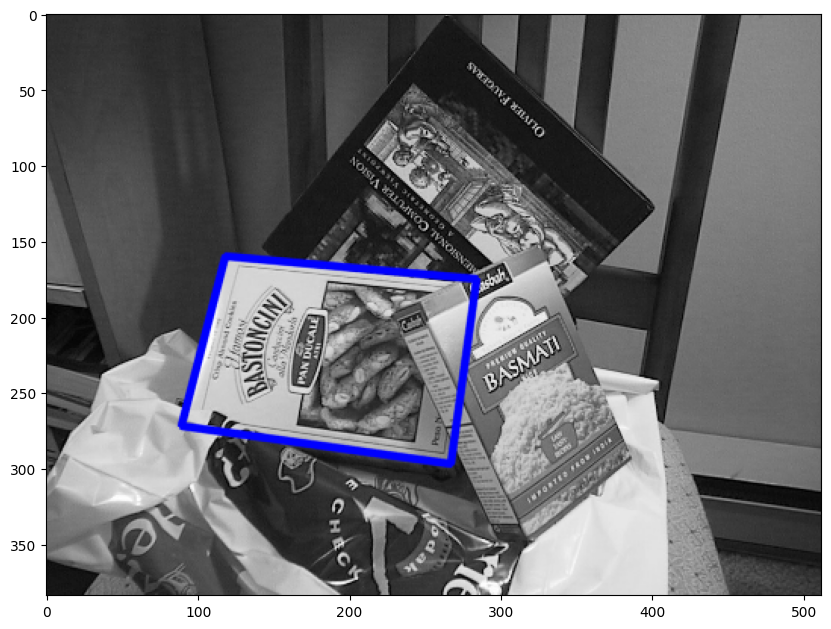

In [ ]:
# %%

# Dibujar el contorno del objeto en la escena
img2 = cv2.polylines(img2, [np.int32(dst)], True, (255,0,0), 3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))


 ### Visualizar Coincidencias de Características con Homografía

 Por último, visualizamos las coincidencias de características usando solo los puntos que cumplen con la homografía.

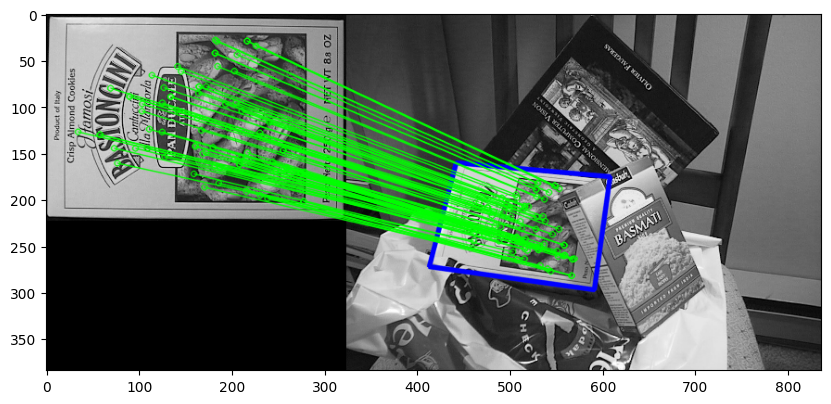

In [ ]:
# %%

draw_params = dict(matchColor = (0,255,0),  # Dibujar coincidencias en color verde
                   singlePointColor = None,
                   matchesMask = matchesMask,  # Dibujar solo coincidencias válidas
                   flags = 2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))


 En esta visualización, los puntos clave que coinciden están conectados por líneas verdes. Solo se muestran los puntos que cumplen con la homografía, lo cual significa que están alineados en el mismo plano y representan la ubicación del objeto en la escena.